In [53]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

class KRR(BaseEstimator, RegressorMixin):

    def __init__(self, kernel_func ,store_kernel, sigma=None, lamb=None, kpca_ncmps=None):

        """
        User must provide a kernelfunction, 
        sigma and lambda are optinal for initialization
        """

        self.kernel_func  = kernel_func        # kernelfunction, no default
        self.store_kernel = store_kernel       # or False
        self.sigma        = sigma or 1.0       # sigma value, 1 default
        self.lamb         = lamb  or 1e-7      # lambda value, 1e-7 default
        self.kpca_ncmps   = kpca_ncmps or 2    # number of components for kpca, 2 default
        
        
        
        """
        get_params and set_params are used by sklearn e.g. for hyperparameter
        optimization
        """

    def get_params(self, deep=True):

        return {"kernel_func":self.kernel_func,"store_kernel":self.store_kernel,"sigma": self.sigma, "lamb": self.lamb, }

    def set_params(self, **parameters):

        self.kernel_func   = parameters["kernel_func"]
        self.store_kernel  = parameters["store_kernel"]
        self.sigma         = parameters["sigma"]
        self.lamb          = parameters["lamb"]      
        
        
        return self

        """
        Obtain the regression coefficients alpha and
        save the training representations because they are 
        needed for predictions
        """
    
    def fit(self, X, y):

        if self.store_kernel:

            try:
                Kernel_train  = np.load("Ktrain_{}_{}.npy".format(self.sigma, self.lamb))

            except:
                Kernel_train  = self.kernel_func(X,X, self.sigma)
                for i in range(Kernel_train.shape[0]):
                    Kernel_train[i, i] += self.lamb


                np.save("Ktrain_{}_{}".format(self.sigma, self.lamb),Kernel_train)

        else:
            Kernel_train  = self.kernel_func(X,X, self.sigma)
            for i in range(Kernel_train.shape[0]):
                Kernel_train[i, i] += self.lamb



   
        self.ALPHA_SOL = np.linalg.solve(Kernel_train, y)
        self.XTRAIN    = X
        
        return self
    
        """
        Make the predictions for query representations Xry
        """

    def predict(self, Xqry):

        Kernel_test     = self.kernel_func(self.XTRAIN, Xqry, self.sigma)
        pred            = np.dot(self.ALPHA_SOL, Kernel_test)
        
        return pred
    
        """
        Make a kernel-pca, by first going to kernel space and 
        performing a pca afterwards, by default 
        returns the first two components
        """

    def kpca(self, X):
        Kernel_train  = self.kernel_func(X,X, self.sigma)

        from sklearn.decomposition import PCA

        pca     = PCA(n_components=self.kpca_ncmps)
        kpca    = pca.fit_transform(Kernel_train)

        return kpca

**1 d funktion  Example**

In [54]:
import numpy as np
import numpy.linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import numba
#from numba import jit
#from math import sqrt


#@jit
def fast_distance(xa, xb):

    if len(xa.shape) == 1:
        measure = abs
    else:
        measure = LA.norm


    dmat = np.zeros((len(xa),len(xb) ))

    if np.array_equal(xa, xb):
        for i in range(len(xa)):
            for j in range(i+1, len(xb)):
                #curr_d = sqrt((locs[i,0] - locs[j,0])**2 + (locs[i,1] - locs[j,1])**2 + (locs[i,2] - locs[j,2])**2)
                curr_d = measure(xa[i]-xb[j])
                dmat[i, j] = curr_d
                dmat[j, i] = curr_d

    else:
        for i in range(len(xa)):
            for j in range(len(xb)):
                curr_d = measure(xa[i]-xb[j])
                dmat[i, j] = curr_d

    return dmat




def kernel_1d_fct_laplace(Xa, Xb, sigma):

    dist = fast_distance(Xa, Xb)
    
    return np.exp(-sigma* dist)


def kernel_1d_fct_gauss(Xa, Xb, sigma):

    dist = fast_distance(Xa, Xb)
    
    return np.exp(-sigma* dist**2)    
    
ndata = 100
X = np.linspace(1, 7, ndata)
# make a function that is complicated to fit
y = -5 *np.exp(-X)*np.sin(-X)*np.cos(X**2)   +  np.random.normal(0,1e-8,ndata) #* np.exp(X**2+1) #*np.arctan(np.pi*X)


regressor = KRR(kernel_1d_fct_laplace, store_kernel=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,shuffle=True, random_state=666)
param_grid = [{"krr__sigma": [10**(i) for i in range(-4, 4)], "krr__lamb":[10**(i) for i in range(-8, -1)], "krr__kernel_func": [kernel_1d_fct_laplace,kernel_1d_fct_gauss ], "krr__store_kernel":[True]}]
pipe = Pipeline([ ('krr', regressor) ])
grid_search = 0
grid_search = GridSearchCV(pipe, param_grid, cv = 5, return_train_score=True, verbose=1, n_jobs=-1 )
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
regressor = best_model['krr']
print(regressor)
print(regressor.sigma)
print(regressor.lamb)
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 50 is different from 40)

In [39]:
regressor.store_kernel

True

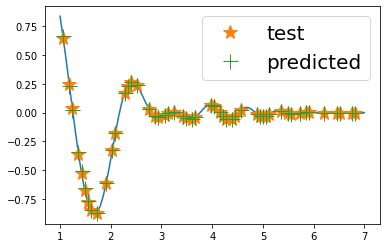

In [29]:
plt.plot(X, y, "-")
plt.plot( X_test, y_test,  "*",ms=15,label='test')
plt.plot( X_test, y_pred,  "+",ms=15,label='predicted')
plt.legend(fontsize=20)

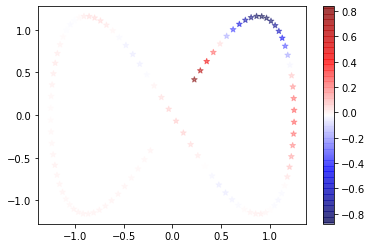

In [21]:
fig, ax = plt.subplots()
regressor.kpca_ncmps = 3
two_dim = regressor.kpca(X)
formation = ax.scatter(two_dim[:,0],two_dim[:,2],marker="*", c=y,vmin=np.min(y), vmax=np.max(y), alpha=0.5, cmap='seismic')
cbar = fig.colorbar(formation, ax=ax)